# Project 3 - 02 : Modelization

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# config
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.options.display.max_colwidth = 500

In [3]:
data = pd.read_csv('Pelec_04_data/cleaned_data.csv', sep=',')
print("{} rows / {} columns".format(data.shape[0], data.shape[1]))
data.head()

1642 rows / 22 columns


,buildingType,primaryPropertyType,councilDistrictCode,neighborhood,nb_buildings,nb_floors,propertyGFA_total,propertyGFA_parking,propertyGFABuilding,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,energystar_score,siteEnergyUse_kBtu,GHG_emissions_TCO2e,complianceStatus,buildingAge,consumeGas,consumeSteam
0,nonresidential,medical office,3,downtown,1.000,4.000,43813,23086,20727,medical office,45145.000,NaN,NaN,NaN,NaN,76.000,1798899.000,12.540,compliant,20,False,False
1,nonresidential,restaurant\n,7,downtown,1.000,2.000,40320,0,40320,restaurant,24514.000,office,15806.000,NaN,NaN,NaN,3816695.000,119.010,compliant,113,True,False
2,nonresidential,other,7,downtown,1.000,7.000,44928,0,44928,other,38706.000,retail store,2660.000,"personal services (health/beauty, dry cleaning, etc)",2600.000,NaN,413919.000,4.430,compliant,111,True,False
3,nonresidential,retail store,5,northwest,1.000,1.000,23696,0,23696,retail store,23829.000,parking,0.000,NaN,NaN,81.000,1392153.000,35.110,compliant,14,True,False
4,nonresidential,worship facility,2,southeast,1.000,2.000,22029,0,22029,NaN,NaN,NaN,NaN,NaN,NaN,100.000,91996.000,0.640,compliant,88,False,False


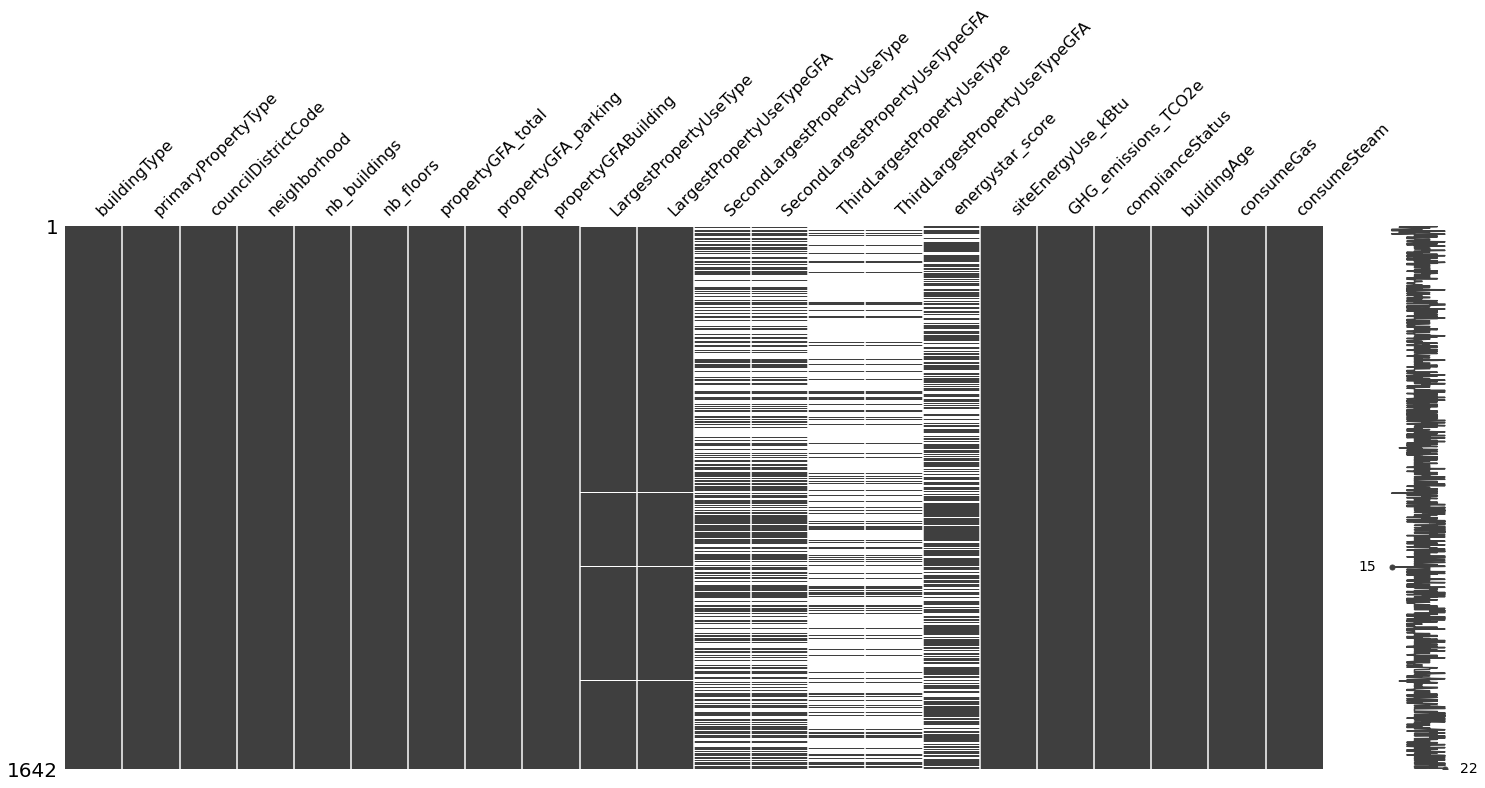

In [3]:
import missingno as msno
msno.matrix(data)

## Preprocessing

In [4]:
data.dtypes.sort_values()

consumeSteam                          bool
consumeGas                            bool
buildingAge                          int64
councilDistrictCode                  int64
propertyGFA_total                    int64
propertyGFA_parking                  int64
propertyGFABuilding                  int64
GHG_emissions_TCO2e                float64
siteEnergyUse_kBtu                 float64
energystar_score                   float64
ThirdLargestPropertyUseTypeGFA     float64
SecondLargestPropertyUseTypeGFA    float64
LargestPropertyUseTypeGFA          float64
nb_floors                          float64
nb_buildings                       float64
ThirdLargestPropertyUseType         object
LargestPropertyUseType              object
neighborhood                        object
complianceStatus                    object
primaryPropertyType                 object
SecondLargestPropertyUseType        object
buildingType                        object
dtype: object

In [5]:
# convert bool feature to numeric
data.consumeGas = data.consumeGas*1
data.consumeSteam = data.consumeSteam*1

### TrainSet / TestSet separation

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.33, shuffle=True, stratify=data.buildingType)

Cannot stratify the separation on multiclassfeature as buildingType

### Categorical features encoding 

In [7]:
# Get non numeric features
categorical_cols = data.columns[data.dtypes==object].tolist()

In [8]:
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=categorical_cols, use_cat_names=True)

# fit on train_set
encoder.fit(train)

# transform train and test
train_encoded = encoder.transform(train)
test_encoded = encoder.transform(test)
print("TrainSet : {} rows / {} columns".format(train_encoded.shape[0], train_encoded.shape[1]))
print("TestSet : {} rows / {} columns".format(test_encoded.shape[0], test_encoded.shape[1]))

TrainSet : 1100 rows / 190 columns
TestSet : 542 rows / 190 columns


C:\Users\Flooow\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Missing values imputation

I will impute the missing values using the kNN algorithm as it is a robust method for imputation. kNN uses the Euclidean distance, as its means of comparing examples.  
In order for all of the features to be of equal importance when calculating the distance, the features must have the same range of values. 
I'll use a MinMaxScaler because NaNs are treated as missing values: disregarded in fit, and maintained in transform.

**Feature scaling**

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# fit on encoded train set
scaler.fit(train_encoded)

# transform encoded train and test sets
train_encoded_scaled = pd.DataFrame(scaler.transform(train_encoded), columns=train_encoded.columns)
test_encoded_scaled = pd.DataFrame(scaler.transform(test_encoded), columns=test_encoded.columns)

**kNN imputation**

In [10]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

# fit on encoded/scaled train set
imputer.fit(train_encoded_scaled)

# transform encoded/scaled train and test sets 
train_encoded_scaled_imp = pd.DataFrame(imputer.transform(train_encoded_scaled), columns=train_encoded_scaled.columns)
test_encoded_scaled_imp = pd.DataFrame(imputer.transform(test_encoded_scaled), columns=test_encoded_scaled.columns)

## Model building

### Baseline models comparison

In [11]:
# To use models already trained, I must use the preprocessed data that was used for training to avoid an error during the predictions
try:
    train_encoded_scaled_imp = pd.read_csv('Pelec_04_data/TrainSet_pp.csv', sep=',')
    test_encoded_scaled_imp = pd.read_csv('Pelec_04_data/TestSet_pp.csv', sep=',')
except FileNotFoundError:
    # saving preprocessed data
    train_encoded_scaled_imp.to_csv('Pelec_04_data/TrainSet_pp.csv', sep=',', index=False)
    test_encoded_scaled_imp.to_csv('Pelec_04_data/TestSet_pp.csv', sep=',', index=False)

**X / y separation**

In [12]:
# to predict CO2 emission
y_train_co2 = train_encoded_scaled_imp.GHG_emissions_TCO2e
y_test_co2 = test_encoded_scaled_imp.GHG_emissions_TCO2e
# To predict the energy consumption
y_train_nrg = train_encoded_scaled_imp.siteEnergyUse_kBtu
y_test_nrg = test_encoded_scaled_imp.siteEnergyUse_kBtu

X_train = train_encoded_scaled_imp.drop(columns=['siteEnergyUse_kBtu', 'GHG_emissions_TCO2e'])
X_test = test_encoded_scaled_imp.drop(columns=['siteEnergyUse_kBtu', 'GHG_emissions_TCO2e'])

In [13]:
print("TrainSet : {} rows / {} columns".format(train_encoded.shape[0], train_encoded.shape[1]))
print("TestSet : {} rows / {} columns".format(test_encoded.shape[0], test_encoded.shape[1]))

TrainSet : 1100 rows / 190 columns
TestSet : 542 rows / 190 columns


**Models to test**

In [14]:
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    'ridge': linear_model.Ridge(),
    'lasso': linear_model.Lasso(),
    'rdmforest': RandomForestRegressor(n_jobs=-1),
    'xgb': XGBRegressor(n_jobs=-1)
}
metrics = ['neg_root_mean_squared_error', 'r2']
cv = 10

In [15]:
def compare_models_cv(X_train, y, models:dict, cv:int, metrics:list):
    """Returns the mean score of each metrics applied by cross-validation to passed models"""    
    all_scores = []
    for key in models:
        # calculate the model scores for each y
        partial_scores = cross_validate(models[key], 
                                    X_train, 
                                    y, 
                                    cv=cv,
                                    scoring=metrics, 
                                    return_train_score=True)
        # convert to a dataframe
        partial_scores = pd.DataFrame.from_dict(partial_scores)
        # get mean score for each metrics and pivot the dataframe
        partial_scores = partial_scores.mean().to_frame().T
        # add the model name into the df
        partial_scores['model'] = key
        # add scores to the scoreslist
        all_scores.append(partial_scores)
    # concat all scores into a single df
    all_scores = pd.concat(all_scores, ignore_index=True)
    # set the model name as index
    all_scores = all_scores.set_index('model')
    return all_scores

In [16]:
co2_mean_scores = compare_models_cv(X_train, y_train_co2, models, cv, metrics)
co2_mean_scores['test_neg_root_mean_squared_error'] = co2_mean_scores['test_neg_root_mean_squared_error'] * -1
co2_mean_scores['train_neg_root_mean_squared_error'] = co2_mean_scores['train_neg_root_mean_squared_error'] * -1
co2_mean_scores

,fit_time,score_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
model,,,,,,
ridge,0.009,0.005,0.078,0.065,0.386,0.624
lasso,0.009,0.004,0.102,0.105,-0.015,0.000
rdmforest,0.725,0.021,0.073,0.028,0.466,0.928
xgb,0.343,0.013,0.081,0.006,0.330,0.997


In [17]:
nrg_mean_scores = compare_models_cv(X_train, y_train_nrg, models, cv, metrics)
nrg_mean_scores['test_neg_root_mean_squared_error'] = nrg_mean_scores['test_neg_root_mean_squared_error'] * -1
nrg_mean_scores['train_neg_root_mean_squared_error'] = nrg_mean_scores['train_neg_root_mean_squared_error'] * -1
nrg_mean_scores

,fit_time,score_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
model,,,,,,
ridge,0.010,0.005,0.095,0.077,0.684,0.800
lasso,0.008,0.004,0.170,0.171,-0.012,0.000
rdmforest,0.423,0.019,0.089,0.035,0.719,0.959
xgb,0.347,0.013,0.095,0.007,0.680,0.998


In [18]:
def print_grouped_barplot(df, title):
    """ Display a grouped bar plot to globally compare the 4 models"""
    barWidth = 0.1 # # bars width
    x = np.arange(len(df.index)) # x postion of each group
    fig, ax = plt.subplots(figsize=(10,6))
    # set height of bars
    b1 = df['fit_time']
    b2 = df['score_time']
    b3 = df['train_neg_root_mean_squared_error']
    b4 = df['test_neg_root_mean_squared_error']
    b5 = df['train_r2']
    b6 = df['test_r2']
    # Make the plot
    r1 = ax.bar(x-(3*barWidth-barWidth/2), b1, color='#3593DC', width=barWidth, edgecolor='white', label='Fit Time')
    r2 = ax.bar(x-(2*barWidth-barWidth/2), b2, color='#59F0FF', width=barWidth, edgecolor='white', label='Score Time')
    r3 = ax.bar(x-barWidth/2, b3, color='#FAE603', width=barWidth, edgecolor='white', label='Train RMSE')
    r4 = ax.bar(x+barWidth/2, b4, color='#FF8019', width=barWidth, edgecolor='white', label='Test RMSE')
    r5 = ax.bar(x+(2*barWidth-barWidth/2), b5, color='#78F029', width=barWidth, edgecolor='white', label='Train R²')
    r6 = ax.bar(x+(3*barWidth-barWidth/2), b6, color='#2DB42D', width=barWidth, edgecolor='white', label='Test R²')
    ax.set_ylabel('Scores')
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(df.index)
    ax.legend() # Create legend 
    plt.show()

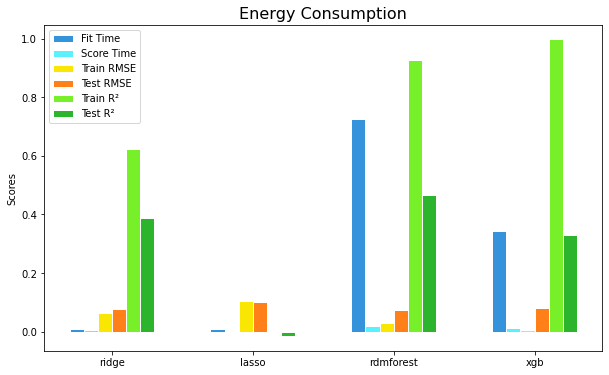

In [19]:
print_grouped_barplot(co2_mean_scores, 'Energy Consumption')

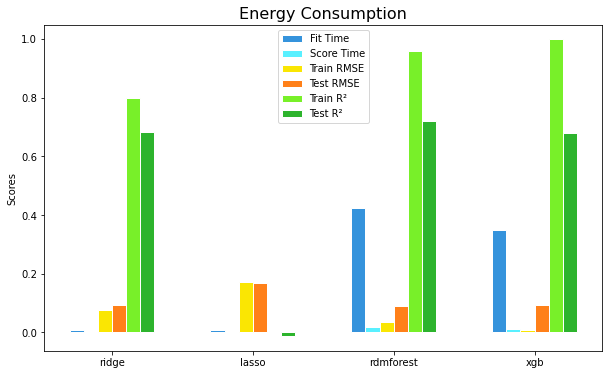

In [20]:
print_grouped_barplot(nrg_mean_scores, 'Energy Consumption')

In [21]:
def print_multi_barplot(df, fig_title):
    """Display a barplot per metrics to compare more precisely the 4 models"""
    fig, axs = plt.subplots(3, 2, figsize=(7,8))        
    axs[0, 0].bar(df.index, df['fit_time'])
    axs[0, 0].set_title("Fit Time")
    axs[0, 1].bar(df.index, df['score_time'])
    axs[0, 1].set_title("Score Time")
    axs[1, 0].bar(df.index, df['train_neg_root_mean_squared_error'], color='orange')
    axs[1, 0].set_title("Train RMSE")
    axs[1, 1].bar(df.index, df['test_neg_root_mean_squared_error'], color='#2DB42D')
    axs[1, 1].set_title("Test RMSE")
    axs[2, 0].bar(df.index, df['train_r2'], color='orange')
    axs[2, 0].set_title("Train R²")
    axs[2, 1].bar(df.index, df['test_r2'], color='#2DB42D')
    axs[2, 1].set_title("Test R²")
    fig.suptitle(fig_title, fontsize=16, fontweight='bold', va='baseline')
    fig.tight_layout()

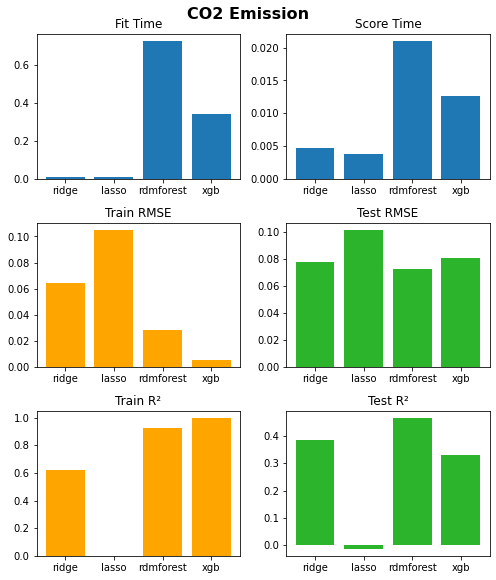

In [22]:
print_multi_barplot(co2_mean_scores, 'CO2 Emission')

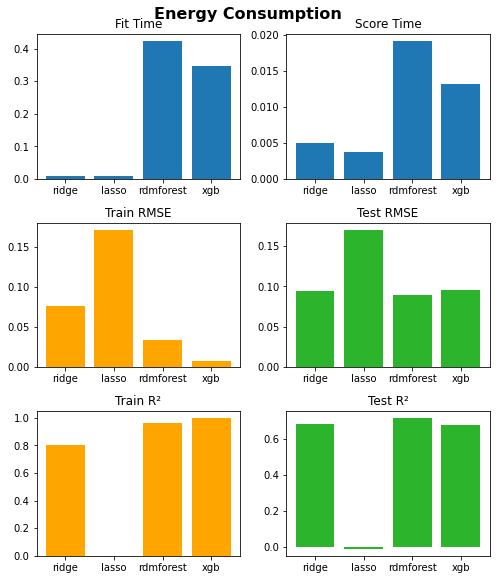

In [23]:
print_multi_barplot(nrg_mean_scores, 'Energy Consumption')

**/!\** : y axis range R² is not the same for train/test

In [24]:
def compare_train_test(train_scores, test_scores, xticklabels, title):
    """Display a grouped bar plot to compare test/train scores"""
    barWidth = 0.3 # bars width
    x_group = np.arange(len(xticklabels)) # x position of each group
    fig, ax = plt.subplots(figsize=(10,5))
    # make the plot
    train_bar = ax.bar(x_group-barWidth/2, train_scores, width=barWidth, color='orange', label='Train scores')
    test_bar = ax.bar(x_group+barWidth/2, test_scores, width=barWidth, color='#2DB42D', label='Test scores')
    # test used to improve display if there is only one model
    if (hasattr(train_scores, '__iter__')==False) or (hasattr(train_scores, '__iter__')==False):
        train_scores = [train_scores]
        test_scores = [test_scores]
        plt.xlim(-1,1)
    for i, v in enumerate(train_scores):
        plt.text(i-barWidth+barWidth/10, v, str('{:.3f}'.format(v)), color='black', fontweight='bold')
    for i, v in enumerate(test_scores):
        plt.text(i+barWidth/10, v, str('{:.3f}'.format(v)), color='black', fontweight='bold')
    # plot settings
    ax.set_ylabel('Scores')
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x_group)
    ax.set_xticklabels(xticklabels)
    ax.legend()
    plt.show()

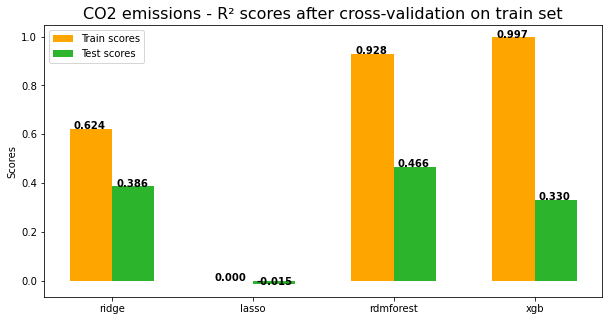

In [25]:
compare_train_test(co2_mean_scores['train_r2'], co2_mean_scores['test_r2'], co2_mean_scores.index, 'CO2 emissions - R² scores after cross-validation on train set')

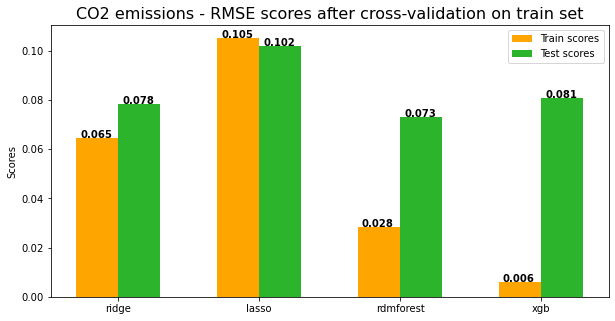

In [26]:
compare_train_test(co2_mean_scores['train_neg_root_mean_squared_error'], co2_mean_scores['test_neg_root_mean_squared_error'], co2_mean_scores.index, 'CO2 emissions - RMSE scores after cross-validation on train set')

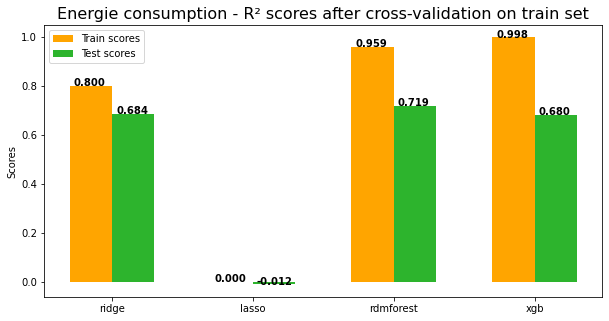

In [27]:
compare_train_test(nrg_mean_scores['train_r2'], nrg_mean_scores['test_r2'], nrg_mean_scores.index, 'Energie consumption - R² scores after cross-validation on train set')

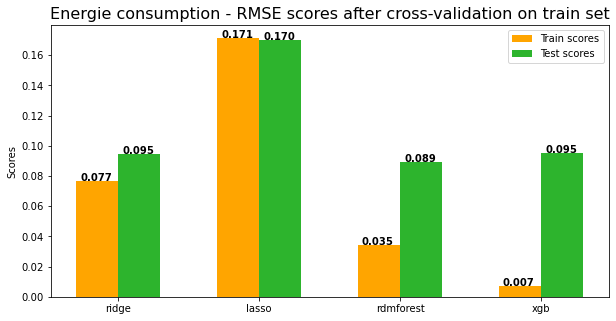

In [28]:
compare_train_test(nrg_mean_scores['train_neg_root_mean_squared_error'], nrg_mean_scores['test_neg_root_mean_squared_error'], nrg_mean_scores.index, 'Energie consumption - RMSE scores after cross-validation on train set')

We can notice several things on these graphs:
- The R² of the Lasso model is negative which means that this model is not suitable for this type of problem (this model also obtains the highest RMSE)
- Non-linear models get better performance but require more training time
- The ridge regression obtains slightly lower performances than the RandomForest model however these performances are obtained much more quickly
- For now the XGB model seems to be a good compromise between performance and training time
- We can also see that the models have difficulty in generalizing, however the optimization of the parameters / hyperparameters should reduce this problem.
- the models are better for energy consumption predictions

### Models optimization

In [29]:
params = {
    'ridge': {
            'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5],
            'fit_intercept': [True, False],
            'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'lasso': {
        'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5],
        'fit_intercept': [True, False],
    },
    'rdmforest': {
        'n_estimators': [50, 100, 200, 300, 400],
        'max_depth': [None, 1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4, 6]
    },
    'xgb': {
        'learning_rate': [0.01, 0.1],
        'max_depth': [None, 2, 4, 8],
        'min_child_weight': [1, 2, 4, 6],
        'subsample': [0.4, 0.6],
        'colsample_bytree': [0.4, 0.6],
        'n_estimators' : [50, 100, 250, 300],
        'objective':['reg:squarederror']
    }
}

In [30]:
import pickle
from sklearn.model_selection import GridSearchCV

def model_tuning(X, y, modelslist, paramslist, cv, title):
    """Optimize models and return the classifier of GridSearchCV"""
    print("### Prediction of {} ###".format(title))
    tuned = {}
    for mod in modelslist:
        clf = GridSearchCV(estimator=modelslist[mod], param_grid=paramslist[mod], scoring='r2', cv=cv, n_jobs=-1)
        print('{} :'.format(mod))
        %time clf.fit(X, y)
        print('    best params : {}\n    best R² : {}\n'.format(clf.best_params_, clf.best_score_))
        tuned[mod] = clf
    return tuned

def load_models(models_name, prefix):
    """Load a list of models and return a dict"""
    models = {}
    for mod in models_name:
        filename = prefix + '_model_' + mod + '.sav'
        loaded_model = pickle.load(open('Pelec_04_data/models/' + filename, 'rb'))
        models[mod] = loaded_model
    return models

def save_models(models, prefix):
    """Save trained models"""
    for mod in models:
        filename = prefix + '_model_' + mod + '.sav'
        file = open('Pelec_04_data/models/' + filename, 'wb')
        pickle.dump(models[mod], file)
        file.close()

In [31]:
# Load trained models if they exist, otherwise start a new training
try:
    tuned_models_co2 = load_models(['ridge', 'lasso', 'rdmforest', 'xgb'], 'co2')
    tuned_models_nrg = load_models(['ridge', 'lasso', 'rdmforest', 'xgb'], 'nrg')
    print('Models loaded')
except FileNotFoundError:
    print('No trained models found, new training starting...\n')
    tuned_models_co2 = model_tuning(X_train, y_train_co2, models, params, cv, 'CO2 emission')
    tuned_models_nrg = model_tuning(X_train, y_train_nrg, models, params, cv, 'Energy consumption')
    save_models(tuned_models_co2, 'co2')
    save_models(tuned_models_nrg, 'nrg')
    print("Models are tuned, trained and saved")

No trained models found, new training starting...

### Prediction of CO2 emission ###
ridge :
Wall time: 19.1 s
    best params : {'alpha': 5, 'fit_intercept': True, 'solver': 'lsqr'}
    best R² : 0.4312622317694566

lasso :
Wall time: 5.76 s
    best params : {'alpha': 0.001, 'fit_intercept': True}
    best R² : 0.4305051799691609

rdmforest :
Wall time: 6min 2s
    best params : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
    best R² : 0.5157881920931265

xgb :
Wall time: 16min 50s
    best params : {'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 50, 'objective': 'reg:squarederror', 'subsample': 0.4}
    best R² : 0.5091214855540895

### Prediction of Energy consumption ###
ridge :
Wall time: 17.7 s
    best params : {'alpha': 5, 'fit_intercept': True, 'solver': 'lsqr'}
    best R² : 0.6882488934978233

lasso :
Wall time: 5.97 s
    best params : {'alpha': 0.001, 'fit_intercept': True}

**After optimization, we can see that the xgb model still get better performance. Closely followed by the RandomForest model**

In [32]:
def print_scores_comparison(scores_dict, title, xlabel_rot=0, xlabel_ha='center'):
    """Display a bar plot to compare models score after tuning"""
    plt.bar(scores_dict.keys(), scores_dict.values())
    for i, v in enumerate(scores_dict.values()):
        plt.text(i-.2, v, str('{:.3f}'.format(v)), color='black', fontweight='bold')
    plt.title(title)
    plt.ylabel('R²')
    plt.xticks(rotation=xlabel_rot, ha=xlabel_ha)
    plt.show()   

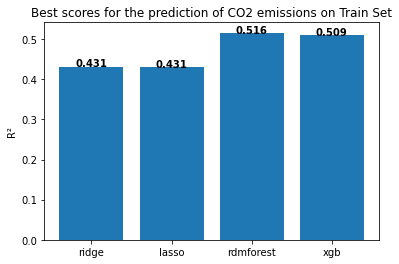

In [33]:
# extract best scores in a new dict
tuned_scores_co2 = {}
for mod in tuned_models_co2:
        tuned_scores_co2[mod] = tuned_models_co2[mod].best_score_
# scores comparison
print_scores_comparison(tuned_scores_co2, 'Best scores for the prediction of CO2 emissions on Train Set') 

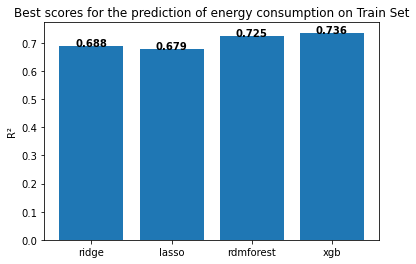

In [34]:
# extract best scores in a new dict
tuned_scores_nrg = {}
for mod in tuned_models_nrg:
        tuned_scores_nrg[mod] = tuned_models_nrg[mod].best_score_
print_scores_comparison(tuned_scores_nrg, 'Best scores for the prediction of energy consumption on Train Set') 

After optimization we can clearly see that nonlinear models get better performance

## Feature importance

EnergyStar score is a tedious value to obtain, so if a model performs well and this column is not important it will be an argument in favor of choosing this model

### Random Forest

In [35]:
def rdm_forest_feature_importance(model, title_prefix):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(15, 50))
    plt.title(title_prefix + ' Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    return indices

**CO2 Emission**

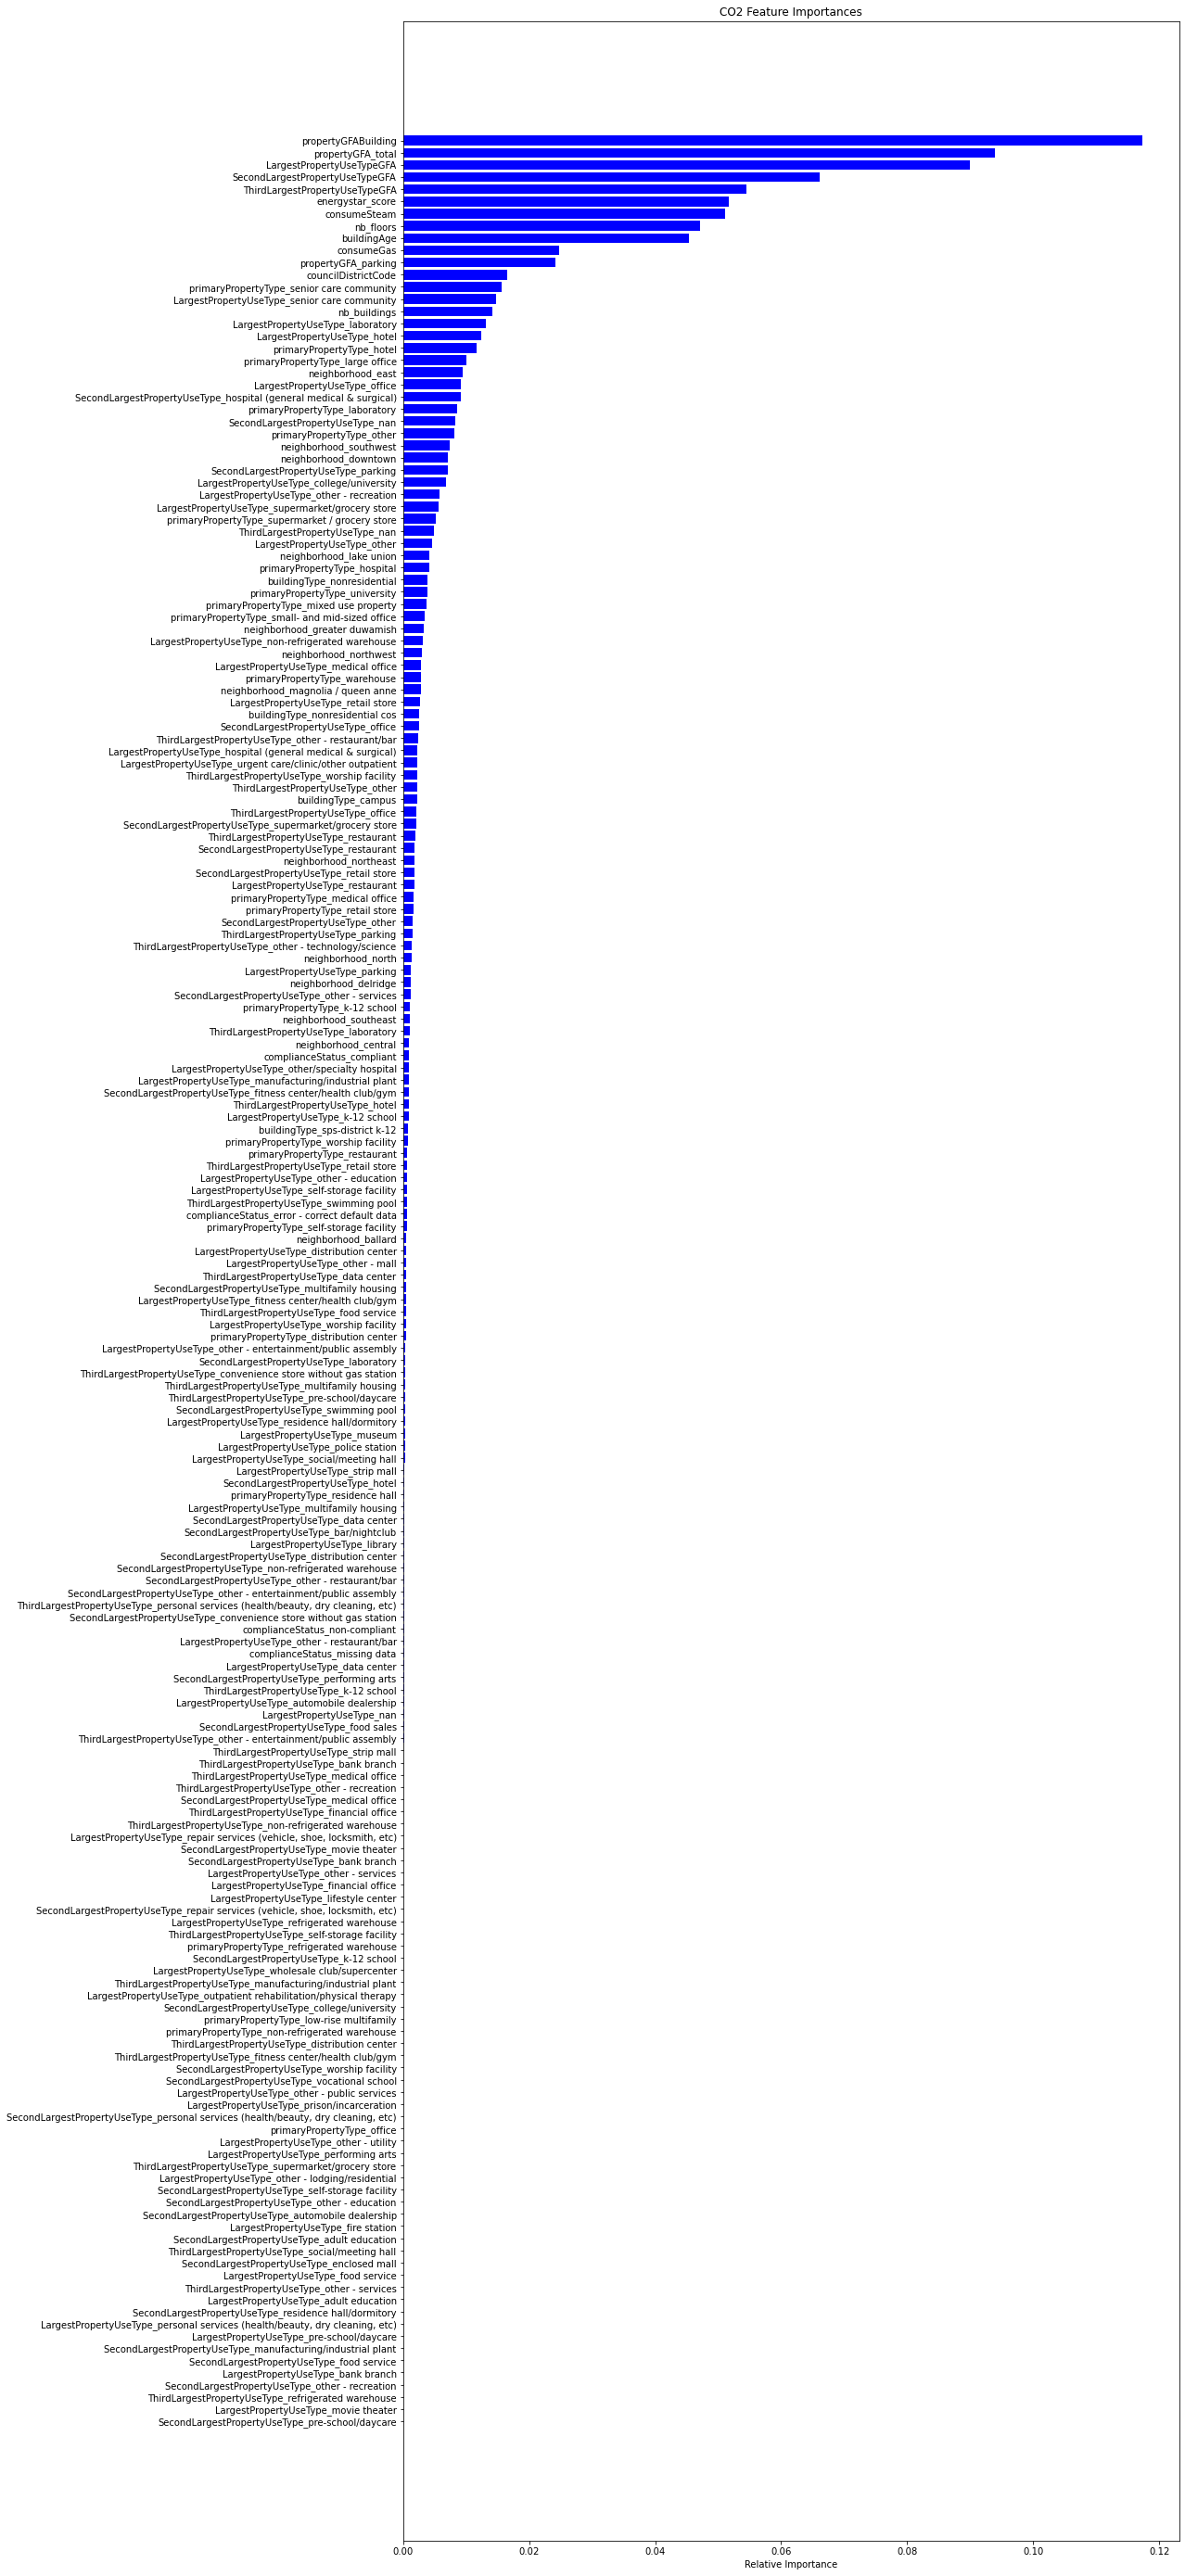

In [36]:
ordered_indices_co2 = rdm_forest_feature_importance(tuned_models_co2['rdmforest'].best_estimator_, 'CO2')

**Energy Consumption**

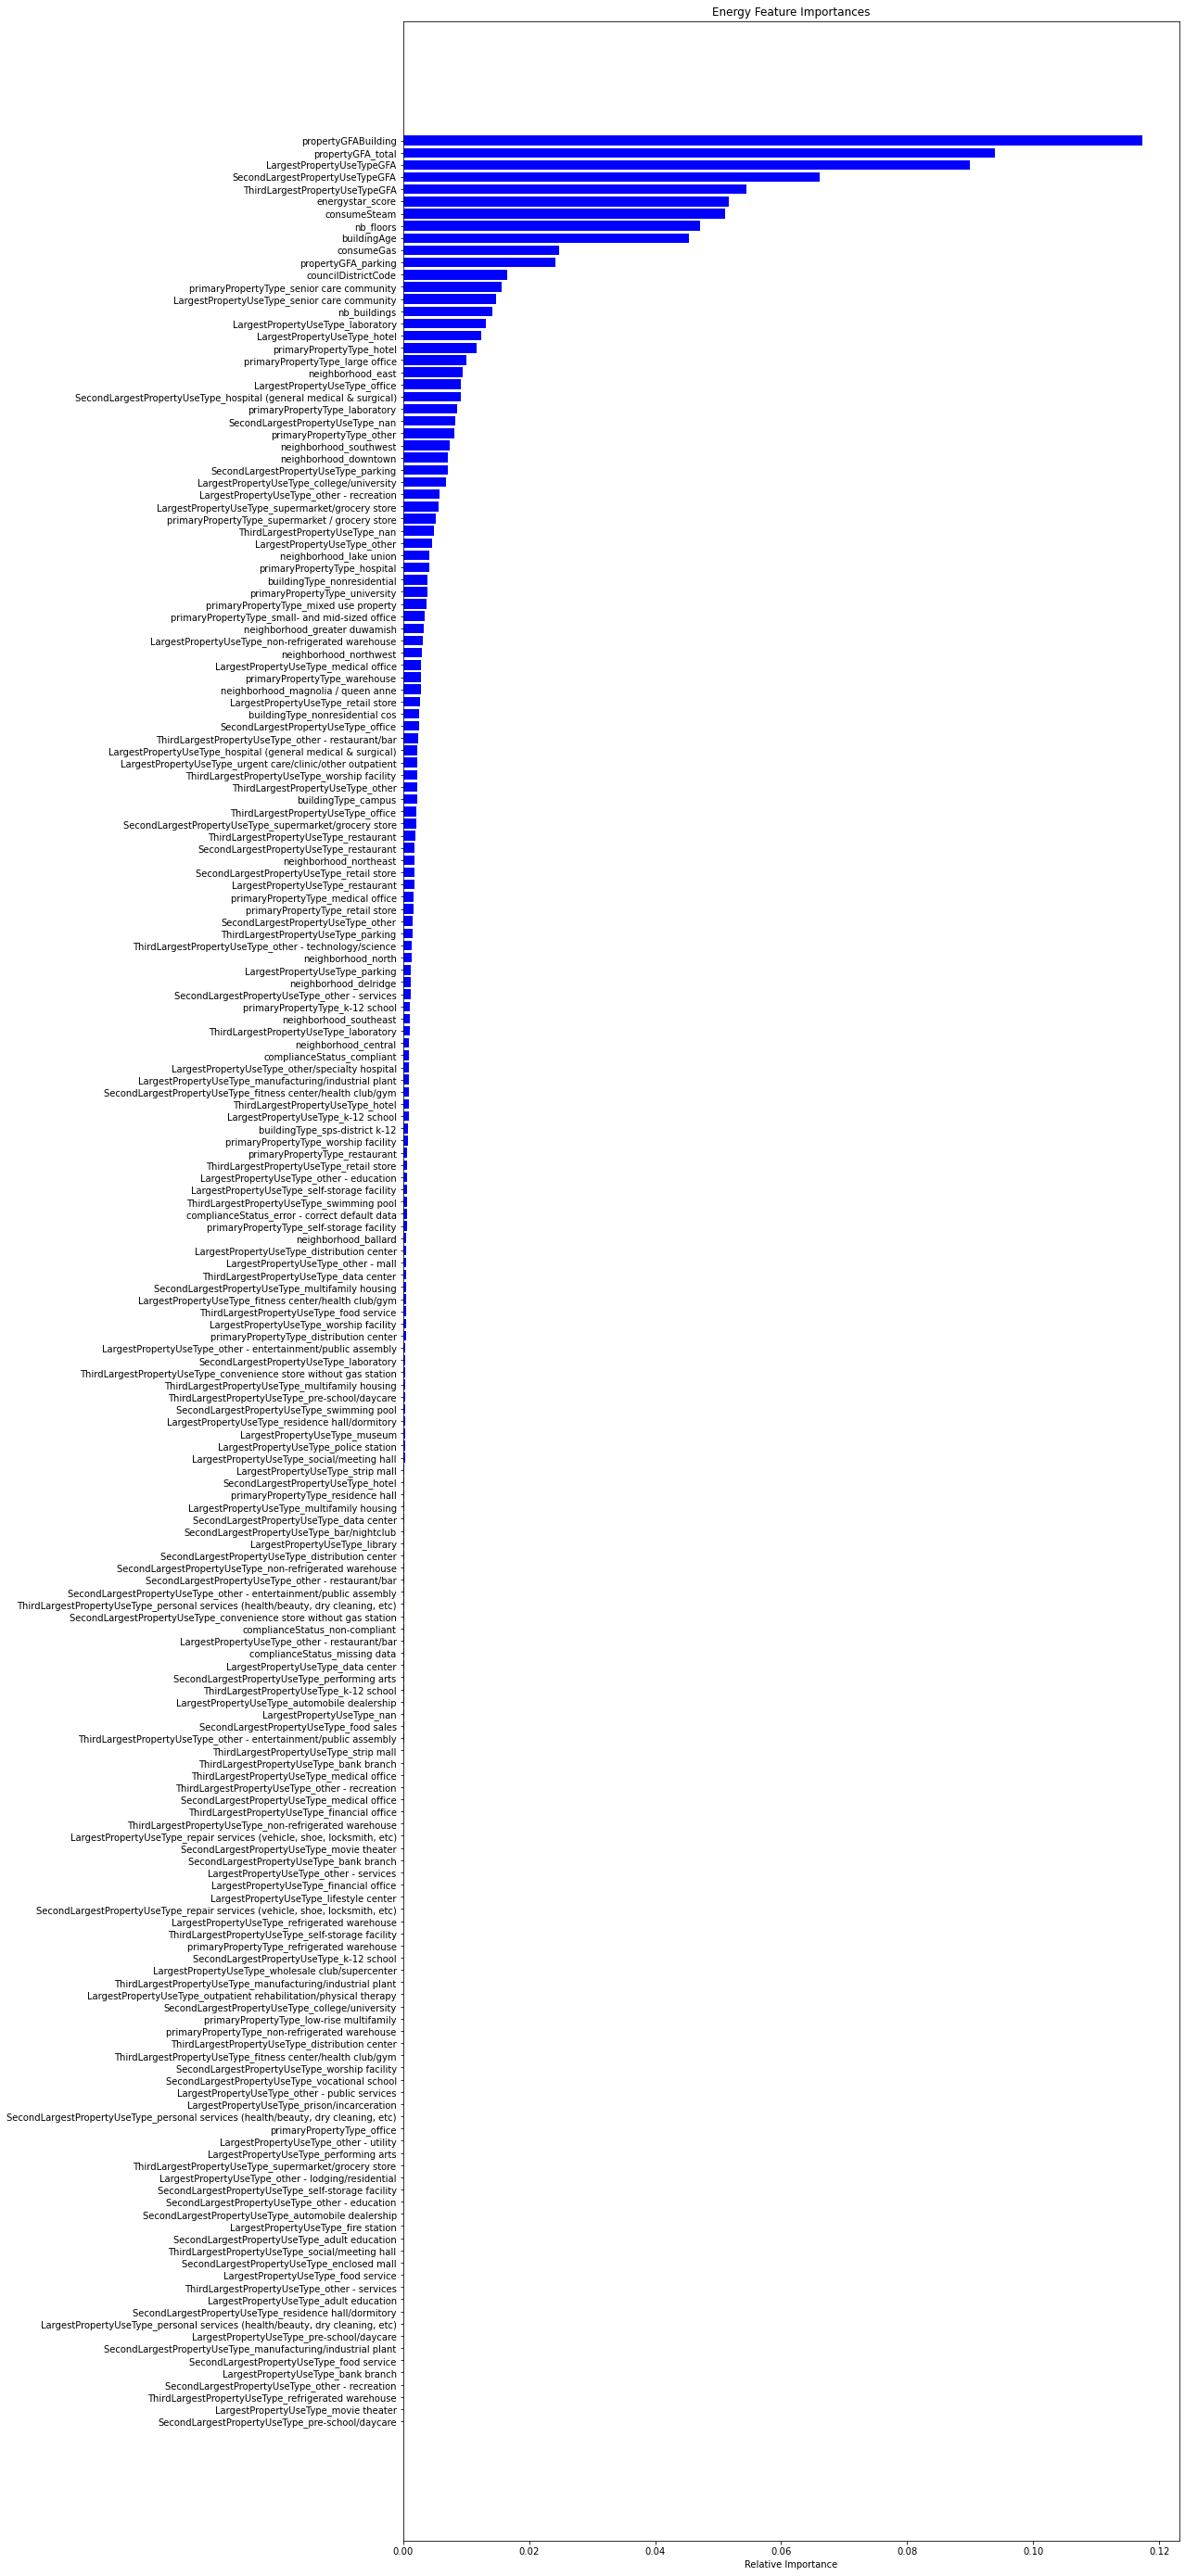

In [37]:
ordered_indices_nrg = rdm_forest_feature_importance(tuned_models_co2['rdmforest'].best_estimator_, 'Energy')

### XGB

**CO2 Emission**

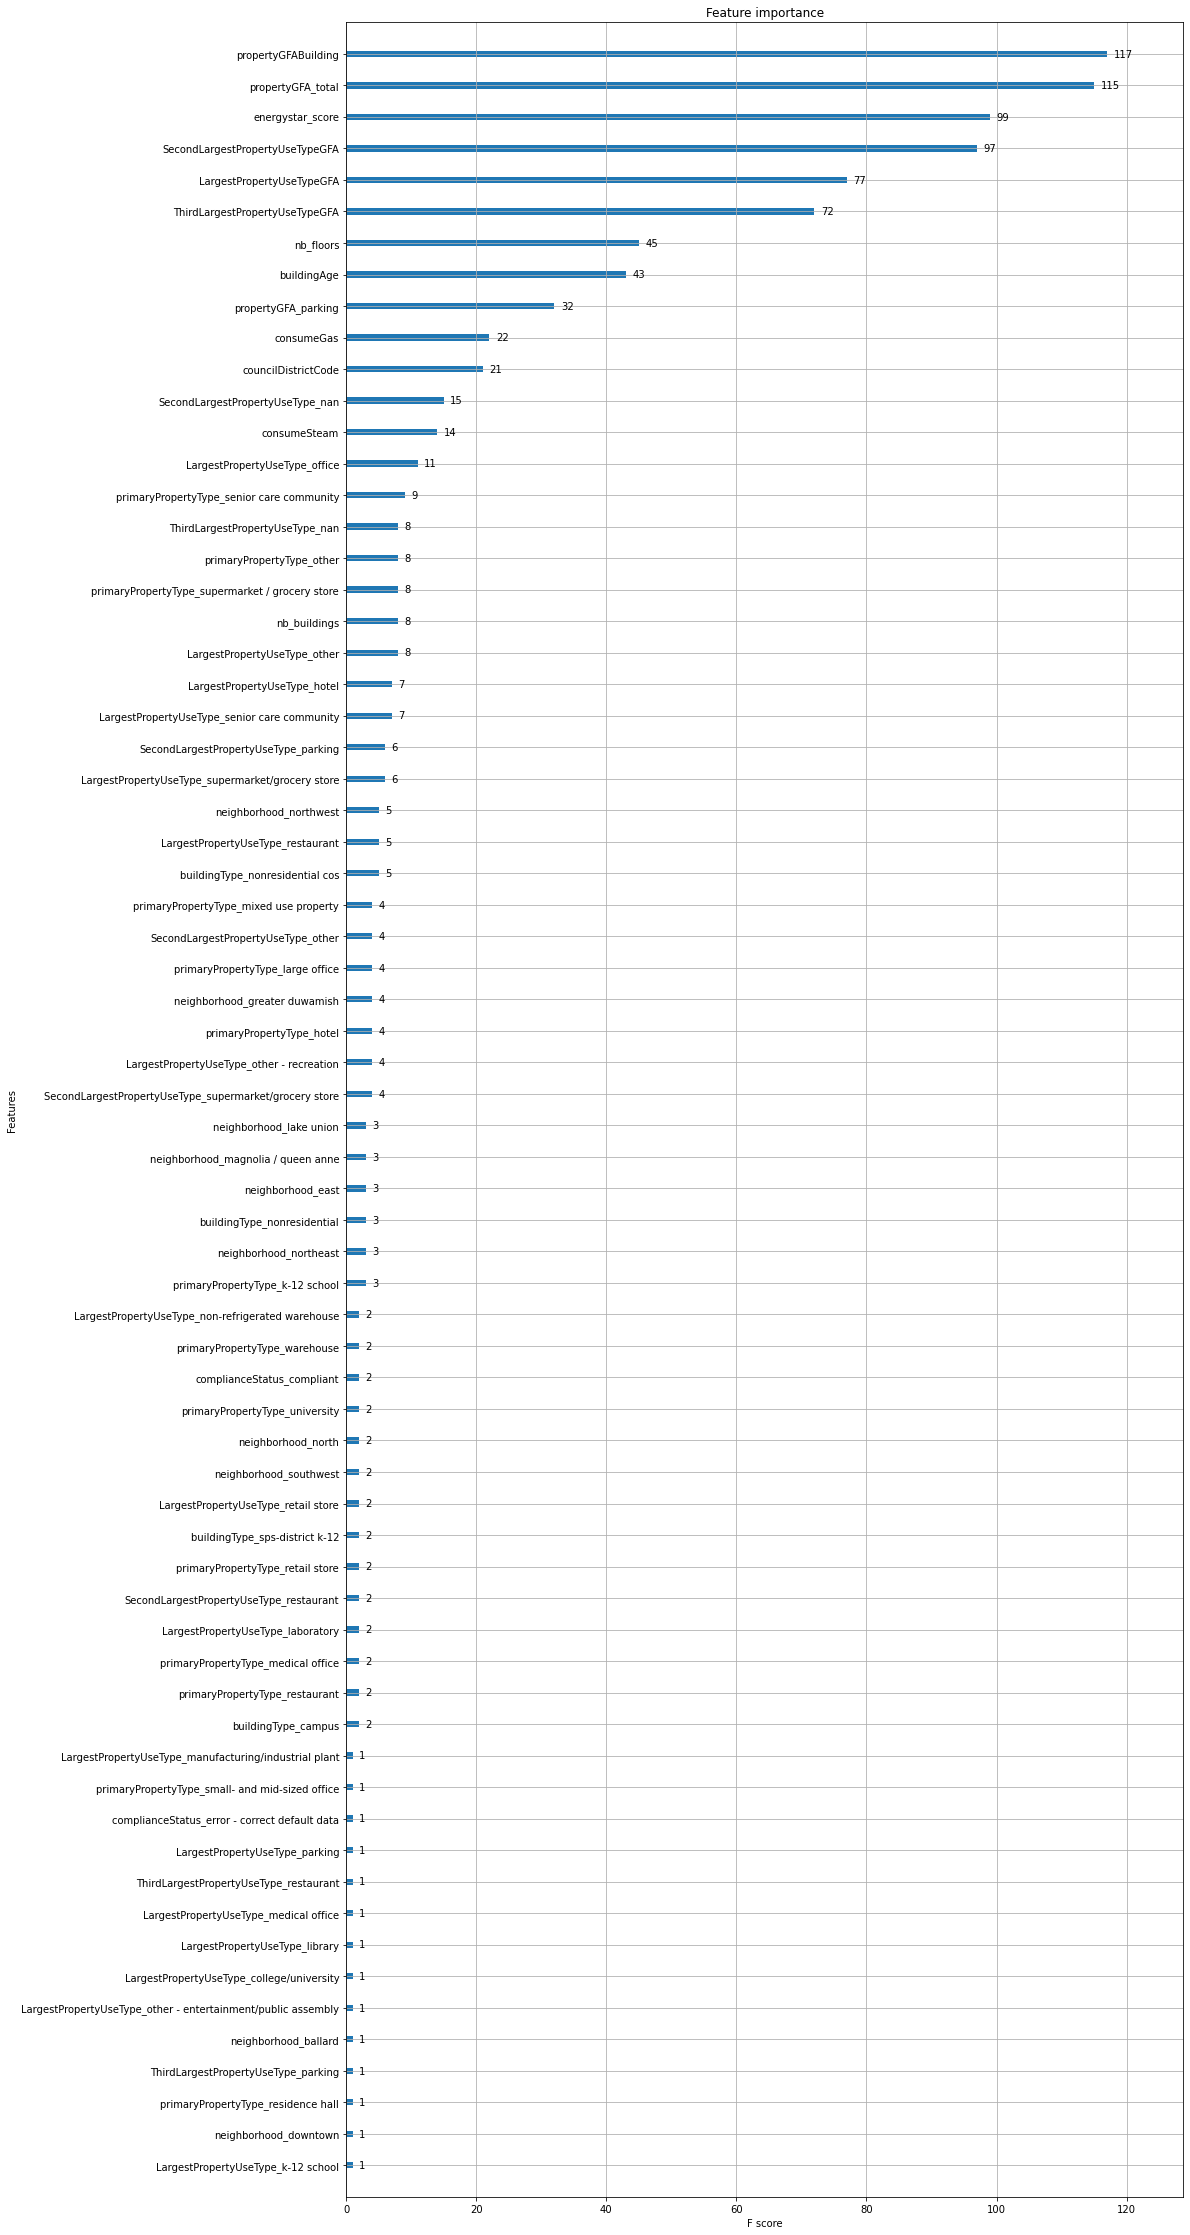

In [62]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(15, 40))
plot_importance(tuned_models_co2['xgb'].best_estimator_, ax=ax)
plt.show()

**Energy Consumption**

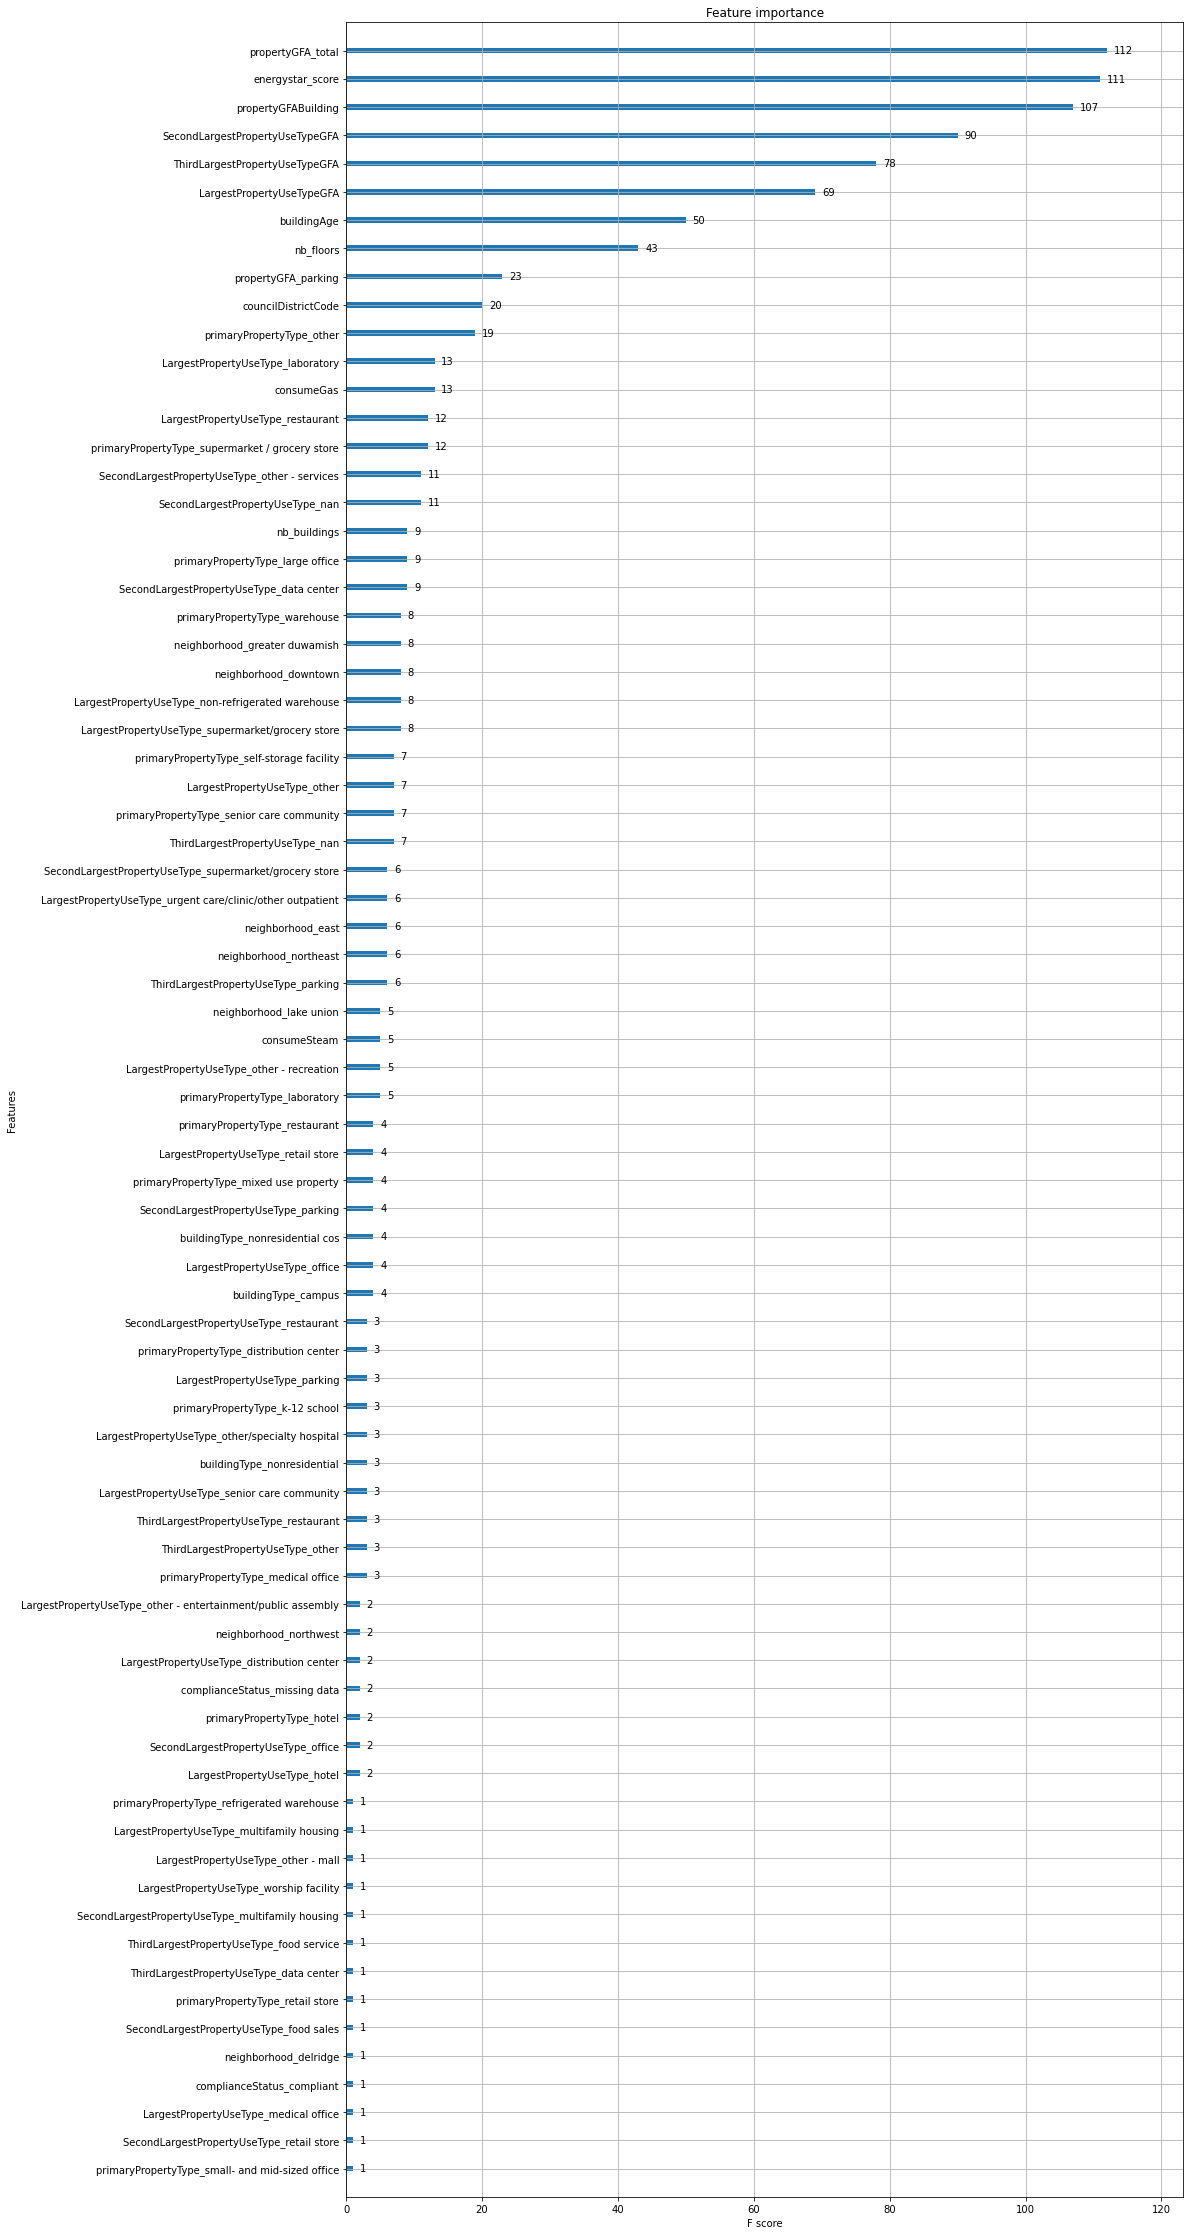

In [63]:
fig, ax = plt.subplots(figsize=(15, 40))
plot_importance(tuned_models_nrg['xgb'].best_estimator_, ax=ax)
plt.show()

## Predictions

In [51]:
from sklearn import metrics

def predict_w_tuned_models(tuned_models, X_test, y_test, model_list):
    """
    Make predictions from a dict of tuned models, the list of models to use and the test dataframe
    Return a dict containing trained models and an other dict containing the best scores
    """
    y_pred = {}
    y_pred_scores = {}
    for mod in model_list:
        y_pred[mod] = tuned_models[mod].predict(X_test)
        y_pred_scores[mod] = metrics.r2_score(y_test, y_pred[mod])
        print('Predictions score for {} model on test set : R²={:.3f}'.format(mod, y_pred_scores[mod], tuned_models[mod].score(X_test, y_test)))
    return y_pred, y_pred_scores

In [52]:
print('CO2 :')
y_pred_co2, y_pred_scores_co2 = predict_w_tuned_models(tuned_models_co2, X_test, y_test_co2, ['xgb'])

CO2 :
Predictions score for xgb model on test set : R²=0.480


In [53]:
print('NRG :')
y_pred_nrg, y_pred_scores_nrg = predict_w_tuned_models(tuned_models_nrg, X_test, y_test_nrg, ['xgb'])

NRG :
Predictions score for xgb model on test set : R²=0.659


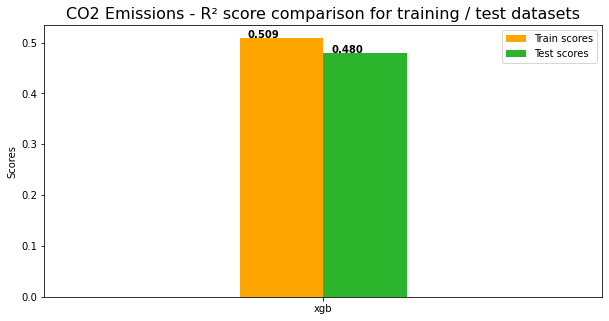

In [54]:
compare_train_test(tuned_scores_co2['xgb'], y_pred_scores_co2['xgb'], ['xgb'], 'CO2 Emissions - R² score comparison for training / test datasets')

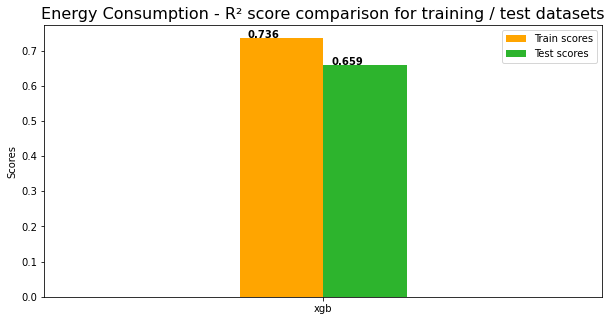

In [55]:
compare_train_test(tuned_scores_nrg['xgb'], y_pred_scores_nrg['xgb'], ['xgb'], 'Energy Consumption - R² score comparison for training / test datasets')

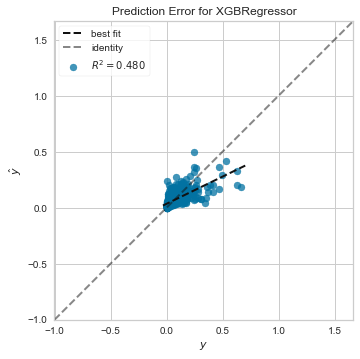

In [79]:
from yellowbrick.regressor import PredictionError
co2_visualizer = PredictionError(tuned_models_co2['xgb'].best_estimator_, identity=True)

co2_visualizer.fit(X_train, y_train_co2)  # Fit the training data to the visualizer
co2_visualizer.score(X_test, y_test_co2)  # Evaluate the model on the test data
co2_visualizer.show()

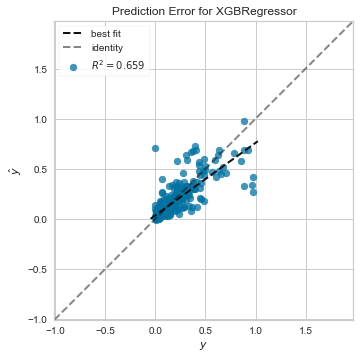

In [80]:
nrg_visualizer = PredictionError(tuned_models_nrg['xgb'].best_estimator_, identity=True)
nrg_visualizer.fit(X_train, y_train_nrg)  # Fit the training data to the visualizer
nrg_visualizer.score(X_test, y_test_nrg)  # Evaluate the model on the test data
nrg_visualizer.show()

### predictions by building type

In [56]:
# Breaks down the test df according to the building types

sliced_df_test_list = {}
buildingType_cols = [col for col in test_encoded_scaled_imp.columns if 'buildingType' in col]
for buildtype in buildingType_cols:
    partial_df = test_encoded_scaled_imp[test_encoded_scaled_imp[buildtype]==1]
    if partial_df.shape[0] != 0:
        # this test is used because buildingType_-2 contains no rows
        sliced_df_test_list[buildtype] = partial_df
        print(buildtype, sliced_df_test_list[buildtype].shape)

buildingType_sps-district k-12 (32, 190)
buildingType_nonresidential (476, 190)
buildingType_nonresidential cos (28, 190)
buildingType_campus (6, 190)


In [57]:

y_pred_co2_per_bt = {}
y_pred_nrg_per_bt = {}
y_pred_scores_co2_per_bt = {}
y_pred_scores_nrg_per_bt = {}
for partial_df_test in sliced_df_test_list:
    print(partial_df_test)
    # separate X/y in each partial test df 
    partial_y_test_co2 = sliced_df_test_list[partial_df_test].GHG_emissions_TCO2e
    partial_y_test_nrg = sliced_df_test_list[partial_df_test].siteEnergyUse_kBtu
    partial_X_test = sliced_df_test_list[partial_df_test].drop(columns=['siteEnergyUse_kBtu', 'GHG_emissions_TCO2e'])
    # then make prediction for each feature to predict)
    print('CO2 :')
    y_pred_co2_per_bt[partial_df_test], y_pred_scores_co2_per_bt[partial_df_test] =  predict_w_tuned_models(tuned_models_co2, partial_X_test, partial_y_test_co2, ['xgb'])
    print('Energy :')
    y_pred_nrg_per_bt[partial_df_test], y_pred_scores_nrg_per_bt[partial_df_test] =  predict_w_tuned_models(tuned_models_nrg, partial_X_test, partial_y_test_nrg, ['xgb'])
    print('\n')

buildingType_sps-district k-12
CO2 :
Predictions score for xgb model on test set : R²=0.611
Energy :
Predictions score for xgb model on test set : R²=0.077


buildingType_nonresidential
CO2 :
Predictions score for xgb model on test set : R²=0.465
Energy :
Predictions score for xgb model on test set : R²=0.655


buildingType_nonresidential cos
CO2 :
Predictions score for xgb model on test set : R²=0.728
Energy :
Predictions score for xgb model on test set : R²=0.791


buildingType_campus
CO2 :
Predictions score for xgb model on test set : R²=0.121
Energy :
Predictions score for xgb model on test set : R²=0.759




In [58]:
y_pred_scores_co2_per_bt

{'buildingType_sps-district k-12': {'xgb': 0.6107839569588474},
 'buildingType_nonresidential': {'xgb': 0.46512936760472323},
 'buildingType_nonresidential cos': {'xgb': 0.728407756200081},
 'buildingType_campus': {'xgb': 0.12118204355051088}}

In [59]:
for bt in y_pred_scores_co2_per_bt:
    y_pred_scores_co2_per_bt[bt] = y_pred_scores_co2_per_bt[bt].get('xgb')

for bt in y_pred_scores_nrg_per_bt:
    y_pred_scores_nrg_per_bt[bt] = y_pred_scores_nrg_per_bt[bt].get('xgb')

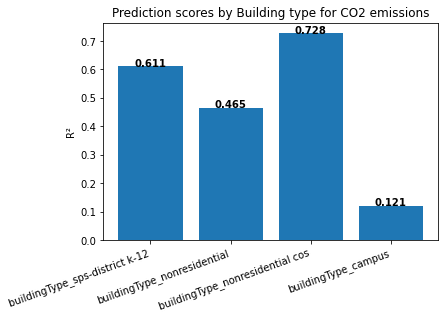

In [60]:
print_scores_comparison(y_pred_scores_co2_per_bt, 'Prediction scores by Building type for CO2 emissions', xlabel_rot=20, xlabel_ha='right')

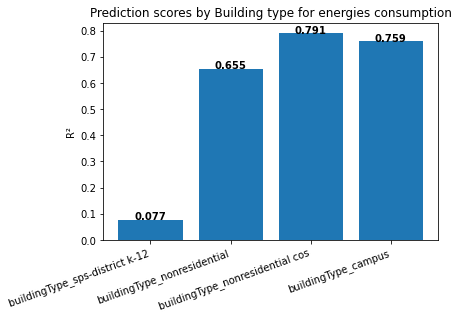

In [61]:
print_scores_comparison(y_pred_scores_nrg_per_bt, 'Prediction scores by Building type for energies consumption', xlabel_rot=20, xlabel_ha='right')